In [6]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("test_pyspark") \
    .config("spark.driver.memory", "100g") \
    .config("spark.executor.memory", "100g") \
    .config("spark.sql.orc.enableVectorizedReader", "false") \
    .config("spark.sql.parquet.columnarReaderBatchSize", "256") \
    .config("spark.sql.orc.columnarReaderBatchSize", "256") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/29 11:04:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/05/29 11:04:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [ ]:
#spark.stop()

In [7]:
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType
from wc_simd.utility import spark_path

df_flat_first_only_with_text_parquet = spark.read.parquet(
    spark_path("../data/plain_text_rendering.parquet"))

# Word count each text

# Define a UDF to count words in a string


def count_words(text):
    if text is None:
        return 0
    return len(text.split())

# Define the UDF for byte size


def byte_size(text):
    if text is None:
        return 0
    return len(text.encode('utf-8'))


count_words_udf = F.udf(count_words, IntegerType())
byte_size_udf = F.udf(byte_size, IntegerType())
df_word_count = (
    df_flat_first_only_with_text_parquet
    .withColumn("word_count", count_words_udf("text"))
    .withColumn("byte_size", byte_size_udf("text"))
    .withColumn("bytes_per_word", F.col("byte_size") / F.col("word_count"))
    .drop("text", "raw_text_url", "download_status")
)

In [ ]:
df_word_count.show(5, truncate=100)

+--------+----------+---------+-----------------+
|      id|word_count|byte_size|   bytes_per_word|
+--------+----------+---------+-----------------+
|a227dajt|     49797|   338515|6.797899471855734|
|a22mnm7y|     13343|    89734|6.725174248669714|
|a235xn8e|     70186|   351872| 5.01342148006725|
|a24krs9c|     89007|   651872|7.323828462929882|
|a25vjcsn|     25805|   141228|5.472892850222825|
+--------+----------+---------+-----------------+
only showing top 5 rows



In [11]:
df_word_count.sample(False, 0.01).show(5, truncate=100)

+--------+----------+---------+------------------+
|      id|word_count|byte_size|    bytes_per_word|
+--------+----------+---------+------------------+
|a4msfyu7|      3499|    22999| 6.573020863103744|
|a69qgh7j|    197266|  1180343|5.9835095759025885|
|a7naac8y|      3571|    20716| 5.801176141136937|
|actmpm58|      6189|    39089|   6.3158830182582|
|adfevwjj|     22662|   135888| 5.996293354514164|
+--------+----------+---------+------------------+
only showing top 5 rows



# Investigate Low/High Bytes per Word

In [8]:
from wc_simd.utility import spark_path

df = spark.read.parquet(
    spark_path("../data/plain_text_rendering.parquet"))

df

DataFrame[id: string, raw_text_url: string, text: string, download_status: string]

In [ ]:
from pyspark.sql import functions as F

low_byte_text = df.select("text").where(F.col("id") == "a235xn8e").collect()[0][0]

# Enforce 80 characters per line
def format_text(text, line_length=80):
    if text is None:
        return None
    words = text.split()
    lines = []
    current_line = ""
    for word in words:
        if len(current_line) + len(word) + 1 <= line_length:
            current_line += " " + word if current_line else word
        else:
            lines.append(current_line)
            current_line = word
    if current_line:
        lines.append(current_line)
    return "\n".join(lines)
formatted_text = format_text(low_byte_text, line_length=80)
print(formatted_text)

UNIVERSITY LIBRARY LEEDS LEEDS UNIVERSITY LIBRARY Classmark: GOOKK/ h OiA 01 06
01123 4753 COOKERY K'Z U, tyooj Digitized by the Internet Archive in 2015
https://archive.org/details/b21532904 Cl Front ispie c je . /t oree ha/tzcC,
rvnj/ a si/i'f 7f /t / Co oC, nt v r /< C/lC -jCft/t U r ' /////<â¢// /<> '.
//<â¢// /r/ Politenels , Jou/'e/ ,/o //<(/t/jfo'i, /ur,t t y/ttff /oaât/t
//te Method /ott> Yo IRne in Tai 1 '' ;!'il III â if LADIES BEST COMPANION; O
R, A Golden Treafure for the Fair Sex, Containing the whole ARTS of COOKERY,
PASTRY, CONFECTIONARY, POTTING, I CANDYING, PICKLING, COLLARING, PRESERVING, l
BREWING,&c. With plain Inftru&ions for making Englifli Wines, from Fruits,
Flowers, &c. To which is added The ART of preferring Beauty. Containing the belt
and eafieft Methods of preparing and making Walhe*, Silences, and Perfumes, &c.
for the Hinds, Neck, Face, and Hair, in fuch a Manner as in a great Meafure to
delay the Ravages of Time on the Features of the Fair Sex. Ljkew

In [8]:

high_byte_text = df.select("text").where(
    F.col("id") == "a24krs9c").collect()[0][0]

formatted_text = format_text(high_byte_text, line_length=80)
print(formatted_text)

______ __ kÂ« a(Â»o3r 1 Pteaa Nummer enthÃ¤lt B8 gÂ«llÂ»n Text. Die MÃ¼nchenÂ«-
Mediz. Wochenschrift erscheint wÃ¶chentlich im Umfang von durchschnittlich 7
Bogen. â¢ Preis der einzelnen Nummer 80 4. â¢ Bezugspreis in Deutschland und
Ausland siehe â¢ â¢ â¢ â¢ unten unter Bezugsbedingungen. .... MÃNCHENER
Zusendungen sind zu adressieren: FÃ¼rdie Redaktion Arnulfstr.-21. Biirozeit der
Redaktion V, -1 Ulir. FÃ¼r Abonnement an 1. F. Lehmann's Verlag, Paul
Hersealrtsse li. FÃ¼r Inserate und Beilagen an Rudolf Mosse, Theatlnerstrass:II.
Inseratenschluss am Donnerstag einer JedeÂ« woÂ»Â»Â». Medizinische
Wochenschrift. ORGAN FÃR AMTLICHE UND PRAKTISCHE ÃRZTE O. v. Angerer,
MÃ¼nchen. W. v. Leube, Stuttgart. Herausgegeben von Ch. BÃ¤umler, A. Bier, M. v.
Gruber, H. Helferich, M. Hofmeier, L. v. Krehi, Fr. Lange, Fre bÃ¼rg . B. Berlin
MÃ¼nchen. Eisenach. WÃ¼rzburg. Heide berÂ» MÃ¼nchen. G. v. Merkel, Fr. Moritz,
Fr. v. MÃ¼ller, F. Penzoldt, B. Spatz, R. Stintzing, NÃ¼rnberg. KÃ¶ln. MÃ¼nc

# Word Counts

In [18]:
# Sum of all word counts

df_word_count_sum = df_word_count.agg(F.sum("word_count").alias("total_word_count")).collect()[0][0]
print(f"Total word count: {df_word_count_sum}")

Total word count: 9806958162


In [19]:
df_word_count.count()

226145

In [8]:
df_word_count_sum/0.01

9727046900.0

# Histogram of word counts

In [ ]:
df_word_count_pd = df_word_count.toPandas()

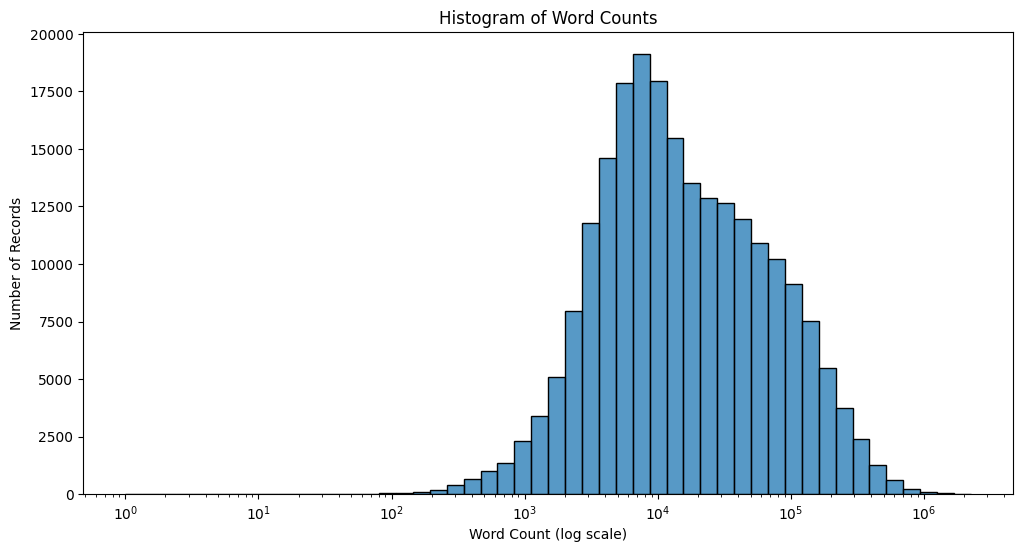

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(12, 6))
ax = sns.histplot(
    df_word_count_pd,
    x="word_count",
    bins=50,
    log_scale=(True, False)
)
plt.xlabel("Word Count (log scale)")
plt.ylabel("Number of Records")
plt.title("Histogram of Word Counts")
plt.show()

# Language

In [9]:
from wc_simd.utility import spark_path

works_df = spark.table("works")
text_df = spark.read.parquet(
    spark_path("../data/plain_text_rendering.parquet"))

In [10]:
from pyspark.sql import functions as F

works_df_lang_exp = works_df.select("id", F.explode("languages"))
works_df_lang_exp.show(5, truncate=100)

+--------+------------------------+
|      id|                     col|
+--------+------------------------+
|hg7q3wz8|{ita, Italian, Language}|
|svxuqzm7|{eng, English, Language}|
|z5he9j2w| {fre, French, Language}|
|vcwcxgxy|{eng, English, Language}|
|vcwcxgxy| {fre, French, Language}|
+--------+------------------------+
only showing top 5 rows



In [13]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns

# Count the number of languages for each work
works_df_lang_count = works_df_lang_exp.groupBy("id").count().withColumnRenamed("count", "num_languages")

# Convert to Pandas DataFrame
works_df_lang_count_pd = works_df_lang_count.toPandas()

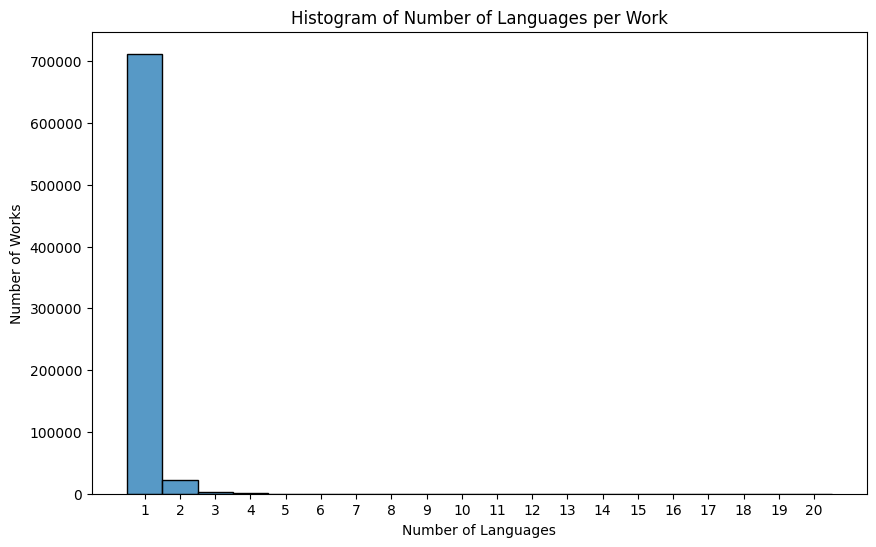

+--------+-------------+
|      id|num_languages|
+--------+-------------+
|na2w6qjv|            1|
|srr7qz3w|            1|
|kct7brvr|            2|
|bywqrqzb|            1|
|qssvyej4|            1|
+--------+-------------+
only showing top 5 rows



In [14]:

# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(data=works_df_lang_count_pd, x="num_languages", discrete=True)
plt.xlabel("Number of Languages")
plt.ylabel("Number of Works")
plt.title("Histogram of Number of Languages per Work")
plt.xticks(range(int(works_df_lang_count_pd["num_languages"].min()), int(works_df_lang_count_pd["num_languages"].max()) + 1))
plt.show()

works_df_lang_count.show(5)

In [7]:
works_df_lang_count.where(F.col("num_languages") > 1).count()

25962

In [10]:
# Show a sample of work IDs with more than 1 language
works_df_lang_count.where(F.col("num_languages") > 1).show(5)

+--------+-------------+
|      id|num_languages|
+--------+-------------+
|kct7brvr|            2|
|xu3d75tf|            2|
|sa3r32x7|            2|
|hxfprh43|            2|
|hnf4sxvu|            2|
+--------+-------------+
only showing top 5 rows



In [11]:
works_df_lang_count.where(F.col("num_languages") > 1).sample(False, 0.01).show(5)

+--------+-------------+
|      id|num_languages|
+--------+-------------+
|r2f9djt9|            2|
|vajwa732|            2|
|vxf3bv3a|            2|
|q7cask3f|            2|
|vv5ktxa3|            2|
+--------+-------------+
only showing top 5 rows



## Eyeball Inspection of Works with > 1 language

- kct7brvr - Book without online viewing (closed stores)
- xu3d75tf - Image (closed stores)
- sa3r32x7 - Book without online viewing (closed stores)
- hxfprh43 - Book without online viewing (closed stores)
- hnf4sxvu - Book without online viewing (closed stores)

- r2f9djt9 - Book without online viewing (closed stores)
- vajwa732 - Book without online viewing (closed stores)
- vxf3bv3a - Correspondence and documents without online viewing (closed stores)
- q7cask3f - Book without online viewing (open shelves)
- vv5ktxa3 - Book without online viewing (closed stores)

With a sample size of 10, it appears that most of the works are not scanned? Hence, there is also no OCR. 

### Conclusion

An observation that all 10 randomly sampled works (from the 25,962 works with more than one language) are "without online viewing" strongly suggests that this characteristic is highly prevalent within this specific subgroup.

However, drawing a conclusion that *all* 25,962 of these works share this characteristic, based solely on a sample of 10, is statistically challenging. Here's why:

*   **Sample Size vs. Population Size:** A sample of 10 is very small compared to a population of 25,962.
*   **Probability of Missing Exceptions:** Even if a small number of exceptions exist, a small sample is quite likely to miss them.
    *   To illustrate, consider a hypothetical scenario: if 0.5% of these works (about 130 works) *did* have online viewing, the probability of randomly selecting 10 works and finding none with online viewing (as you did) would be approximately (1 - 0.005)^10 ≈ 0.951, or 95.1%.
    *   This 95.1% is the likelihood of your specific sample outcome *assuming* that particular number of exceptions (e.g., 130) exists. It is **not** a direct statement that you can be "95.1% confident that at most 130 works have online viewing."
    *   To state "we are X% confident that at most Y works have online viewing," one would typically calculate an upper confidence limit for a proportion. For instance, with 0 events in 10 trials, a common simple method (like the "rule of three") suggests that with roughly 95% confidence, the true proportion of works with online viewing could be up to 3/10 (or 30%). This would correspond to a much larger potential number of exceptions than 130. The small sample size leads to a wide confidence interval.

**Conclusion on Confidence:**
We can have **high confidence** that a very large proportion of the 25,962 works with >1 language are "without online viewing."
However, we would have **low statistical confidence** in the claim that *every single one* of these 25,962 works has no online viewing, based only on this sample of 10. To make such a strong claim about the entire population, or to establish a tighter upper bound on the number of exceptions with high confidence, a much larger sample size would be necessary.

## Find overlap of > 1 language and text renderings (OCR) DataFrame

In [15]:
works_w_renderings_multilang = works_df_lang_count.where(F.col("num_languages") > 1).join(
    text_df, works_df_lang_count.id == text_df.id, "inner"
).select(
    works_df_lang_count.id, "text"
)

In [ ]:
works_w_renderings_multilang.count()

3056

In [ ]:
works_w_renderings_multilang.select("id").sample(False, 0.01).show(30, truncate=100)

+--------+
|      id|
+--------+
|j3ebns3d|
|j2f9xxcq|
|dh8x4vwu|
|qbt2ajp6|
|ep794jpb|
|zey3adqb|
|ky4xhpdc|
|w3v3qf6t|
|vrfda33v|
|fhgd3dve|
|camxjhpg|
|dn9u2xjz|
|g9g783wg|
|pbzdzsxj|
|cj7y6rgs|
|n43mm3q8|
|aju27xhw|
|jy3z5dh5|
|e3pwyk56|
|s9grqcyx|
|nue4yywg|
|apur5ge7|
|yhurq7sx|
|uhrwtske|
|j7n7ybmy|
|e5r7ezev|
|qskrr9pc|
|g55tse8z|
|fub6nbaj|
|cmzptaw2|
+--------+
only showing top 30 rows



In [ ]:
works_df.where(F.col("id") == "j2f9xxcq").select(
    "languages").show(truncate=100)

+--------------------------------------------------+
|                                         languages|
+--------------------------------------------------+
|[{eng, English, Language}, {wel, Welsh, Language}]|
+--------------------------------------------------+



### Observations

- j3ebns3d - 1st Language (eng) is the main language in text rendering
- j2f9xxcq - 1st (eng) and 2nd Language in equal proportions (Welsh to English dictionary)
- dh8x4vwu - 1st Language (eng) is the main language in text rendering
- qbt2ajp6 - 1st Language (eng) is the main language in text rendering
- ep794jpb - 1st Language (ita) is the main language in text rendering 
- zey3adqb - 1st Language (eng) is the main language in text rendering
- ky4xhpdc - 1st Language (frn) is the main language in text rendering 
- w3v3qf6t - 1st Language (ita) is the main language in text rendering
- vrfda33v - 1st (eng) and 2nd Language in equal proportions (Translation with original text)
- fhgd3dve - 1st Language (eng) is the main language in text rendering

### Findings

It is likely that by taking the 1st language in the array, we will get the primary language of the work

## Language Pie Chart

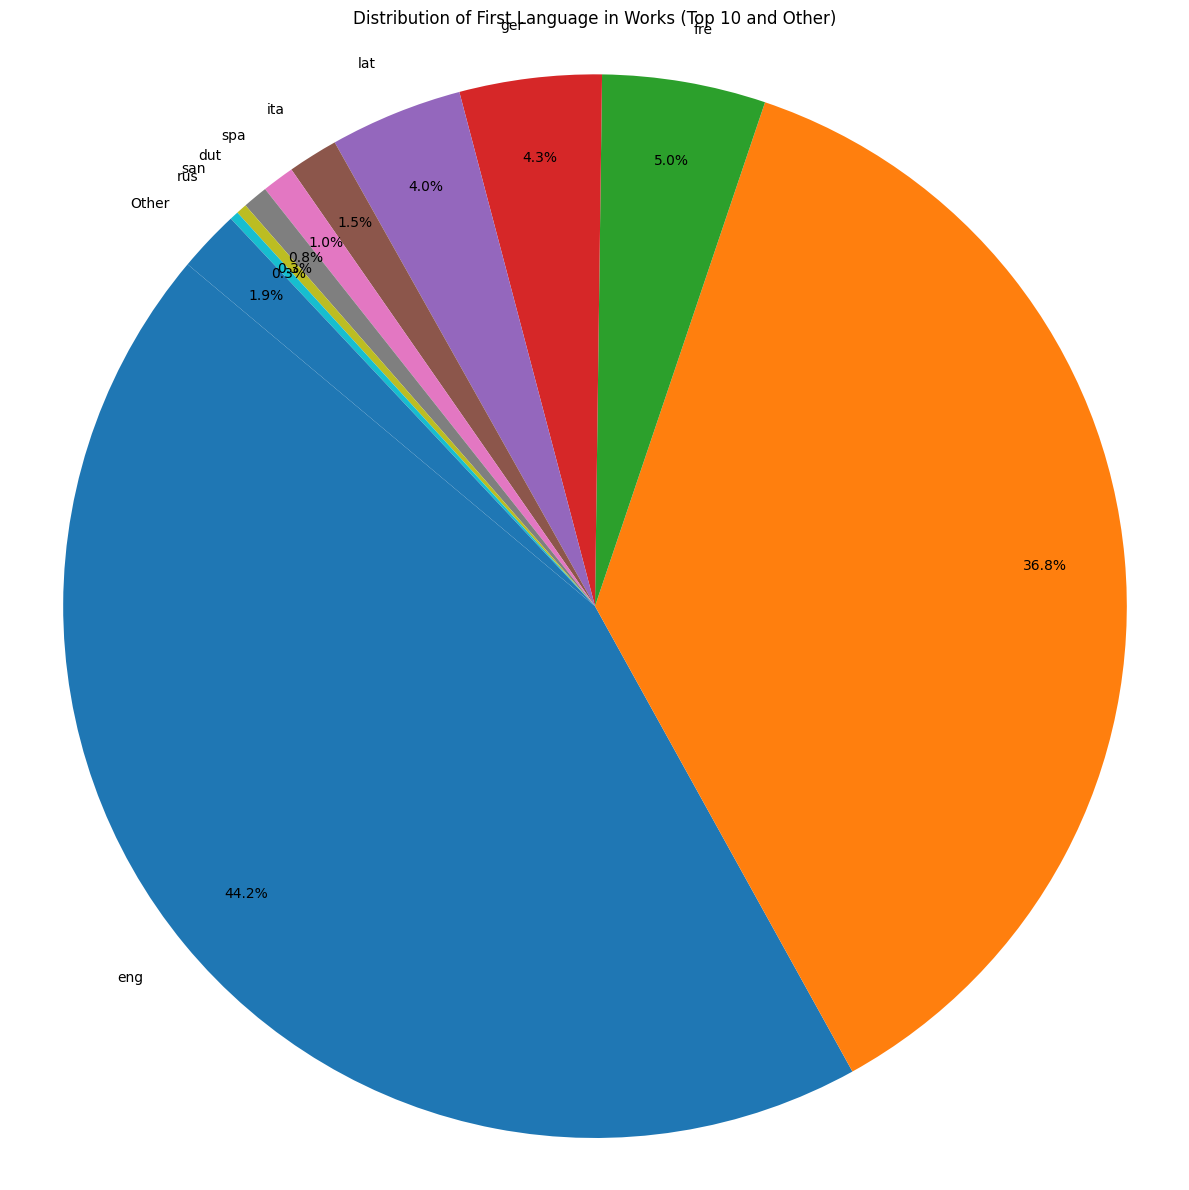

+--------------+------+
|first_language| count|
+--------------+------+
|           eng|515461|
|          NULL|429371|
|           fre| 58000|
|           ger| 50399|
|           lat| 47103|
|           ita| 17867|
|           spa| 11452|
|           dut|  8908|
|           san|  3781|
|           rus|  3122|
|           dan|  2853|
|           tam|  2312|
|           por|  1931|
|           jpn|  1623|
|           chi|  1582|
|           ara|  1528|
|           hin|  1267|
|           swe|  1109|
|           per|   976|
|           pol|   591|
+--------------+------+
only showing top 20 rows



In [7]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Extract the first language from the languages array
works_df_first_lang = works_df.withColumn("first_language", F.col("languages")[0]["id"])

# Count the occurrences of each first language
lang_counts = works_df_first_lang.groupBy("first_language").count().orderBy(F.col("count").desc())

# Convert to Pandas for plotting
lang_counts_pd = lang_counts.toPandas()

# Prepare data for pie chart (Top N + Other)
N = 10  # Number of top languages to display
top_n_lang = lang_counts_pd.head(N)
other_count = lang_counts_pd.iloc[N:]["count"].sum()

if other_count > 0:
    other_df = pd.DataFrame([{"first_language": "Other", "count": other_count}])
    pie_data_pd = pd.concat([top_n_lang, other_df], ignore_index=True)
else:
    pie_data_pd = top_n_lang

# Plot the pie chart
plt.figure(figsize=(12, 12))
plt.pie(
    pie_data_pd["count"],
    labels=pie_data_pd["first_language"],
    autopct='%1.1f%%', # Format percentages
    startangle=140,
    pctdistance=0.85 # Distance of percentage labels from center
)
plt.title(f"Distribution of First Language in Works (Top {N} and Other)")
plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
plt.tight_layout()
plt.show()

lang_counts.show()

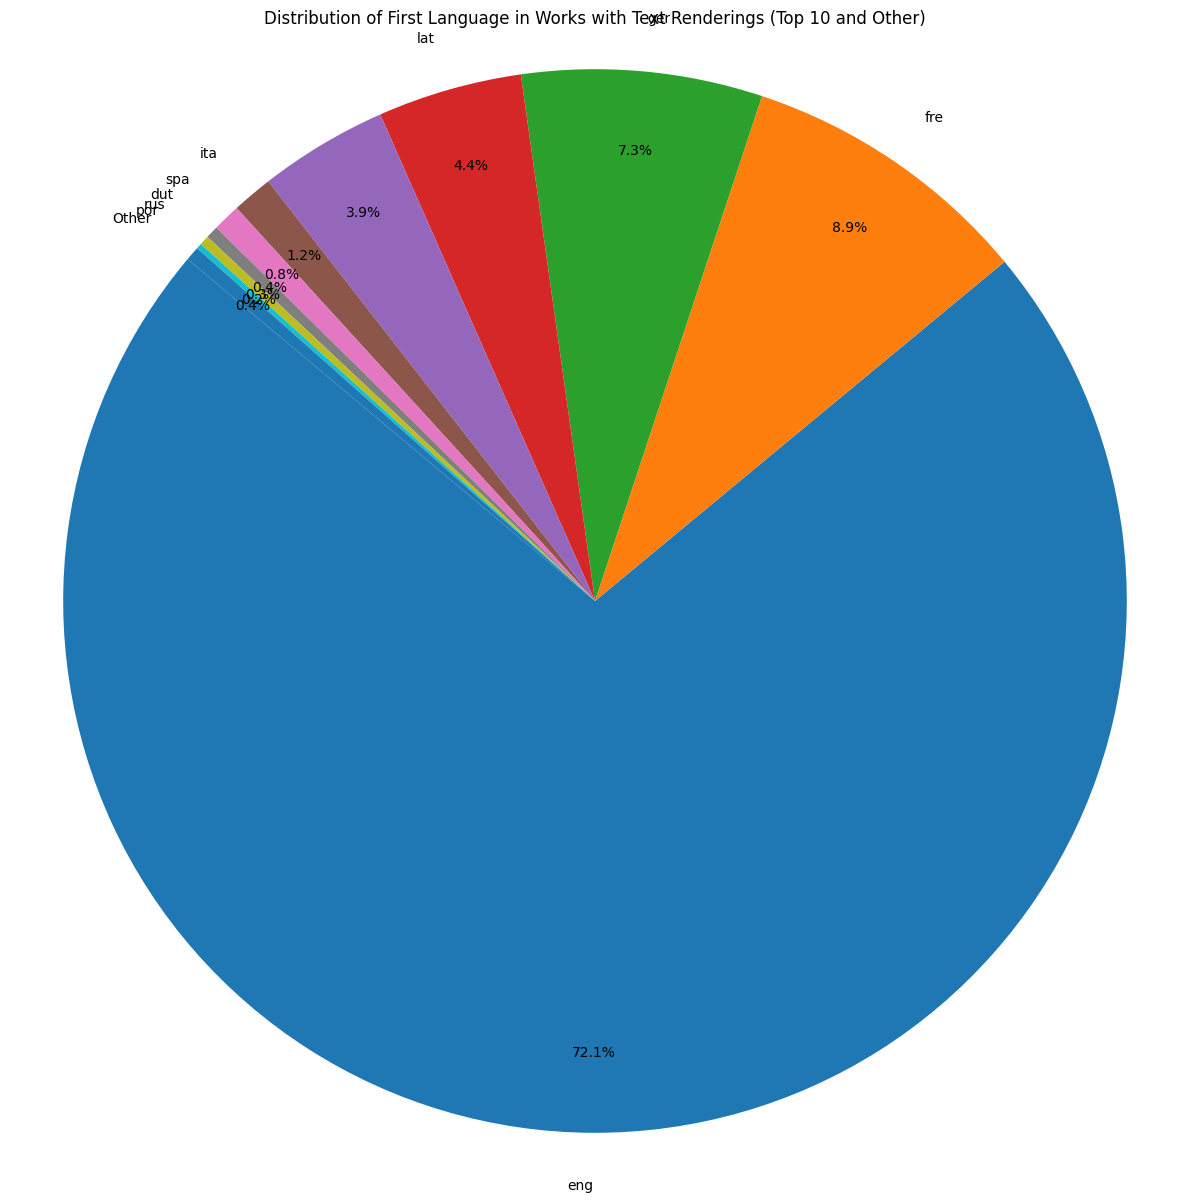

+--------------+------+
|first_language| count|
+--------------+------+
|           eng|163100|
|           fre| 20138|
|           ger| 16536|
|           lat|  9925|
|          NULL|  8847|
|           ita|  2805|
|           spa|  1902|
|           dut|   874|
|           rus|   658|
|           por|   385|
|           swe|   367|
|           dan|   227|
|           hun|    81|
|           nor|    42|
|           heb|    37|
|           gre|    27|
|           cze|    23|
|           pol|    20|
|           grc|    19|
|           san|    16|
+--------------+------+
only showing top 20 rows



In [16]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Perform an inner join between works_df and text_df
works_in_text_df = works_df.join(text_df, works_df.id == text_df.id, "inner").select(works_df["id"], works_df["languages"])

# Extract the first language from the languages array
works_in_text_df_first_lang = works_in_text_df.withColumn("first_language", F.col("languages")[0]["id"])

# Count the occurrences of each first language
lang_counts_in_text = works_in_text_df_first_lang.groupBy("first_language").count().orderBy(F.col("count").desc())

# Convert to Pandas for plotting
lang_counts_in_text_pd = lang_counts_in_text.toPandas()

# Prepare data for pie chart (Top N + Other)
N = 10  # Number of top languages to display
top_n_lang_in_text = lang_counts_in_text_pd.head(N)
other_count_in_text = lang_counts_in_text_pd.iloc[N:]["count"].sum()

if other_count_in_text > 0:
    other_df_in_text = pd.DataFrame([{"first_language": "Other", "count": other_count_in_text}])
    pie_data_in_text_pd = pd.concat([top_n_lang_in_text, other_df_in_text], ignore_index=True)
else:
    pie_data_in_text_pd = top_n_lang_in_text

# Plot the pie chart
plt.figure(figsize=(12, 12))
plt.pie(
    pie_data_in_text_pd["count"],
    labels=pie_data_in_text_pd["first_language"],
    autopct='%1.1f%%', # Format percentages
    startangle=140,
    pctdistance=0.85 # Distance of percentage labels from center
)
plt.title(f"Distribution of First Language in Works with Text Renderings (Top {N} and Other)")
plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
plt.tight_layout()
plt.show()

lang_counts_in_text.show()